In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

# for graph plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# for stop words
from nltk.corpus import stopwords

# for punctuations
import string

# for counting
from collections import Counter
from itertools import chain

# for frequent words
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# for n-gram
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
processed_df = pd.read_csv("Data/processed_train.csv",
                           converters={'text_tokenized': literal_eval, 'text_tokenized_nopunc': literal_eval, 'POS_tagging': literal_eval, 
                                       'POS_tagging_flat': literal_eval, 'lemmatization': literal_eval})
print(processed_df.shape)
processed_df.head()

(159571, 15)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,noise_removed_text,clean_text,text_tokenized,text_tokenized_nopunc,POS_tagging,POS_tagging_flat,lemmatization
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0,Explanation Why the edits made under my userna...,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my...","[explanation, why, the, edits, made, under, my...","[[(explanation, NN), (why, WRB), (the, DT), (e...","[(explanation, NN), (why, WRB), (the, DT), (ed...","[explanation, edits, made, username, hardcore,..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,D'aww! He matches this background colour I am ...,d'aww! he matches this background colour i am ...,"[d'aww, !, he, matches, this, background, colo...","[daww, he, matches, this, background, colour, ...","[[(d'aww, NN), (!, .)], [(he, PRP), (matches, ...","[(d'aww, NN), (!, .), (he, PRP), (matches, VBZ...","[d'aww, match, colour, i, am, seemingly, stuck..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"Hey man, I am really not trying to edit war. I...","hey man, i am really not trying to edit war. i...","[hey, man, ,, i, am, really, not, trying, to, ...","[hey, man, i, am, really, not, trying, to, edi...","[[(hey, NN), (man, NN), (,, ,), (i, JJ), (am, ...","[(hey, NN), (man, NN), (,, ,), (i, JJ), (am, V...","[hey, man, i, am, really, not, trying, edit, w..."
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0,""" More I cannot make any real suggestions on i...",""" more i cannot make any real suggestions on i...","["", more, i, cannot, make, any, real, suggesti...","[more, i, cannot, make, any, real, suggestions...","[[("", IN), (more, JJR), (i, JJ), (cannot, NNS)...","[("", IN), (more, JJR), (i, JJ), (cannot, NNS),...","[more, i, cannot, make, real, suggestion, impr..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"You, sir, are my hero. Any chance you remember...","you, sir, are my hero. any chance you remember...","[you, ,, sir, ,, are, my, hero, ., any, chance...","[you, sir, are, my, hero, any, chance, you, re...","[[(you, PRP), (,, ,), (sir, VB), (,, ,), (are,...","[(you, PRP), (,, ,), (sir, VB), (,, ,), (are, ...","[sir, are, hero, chance, remember, page, is]"


## Category Distribution

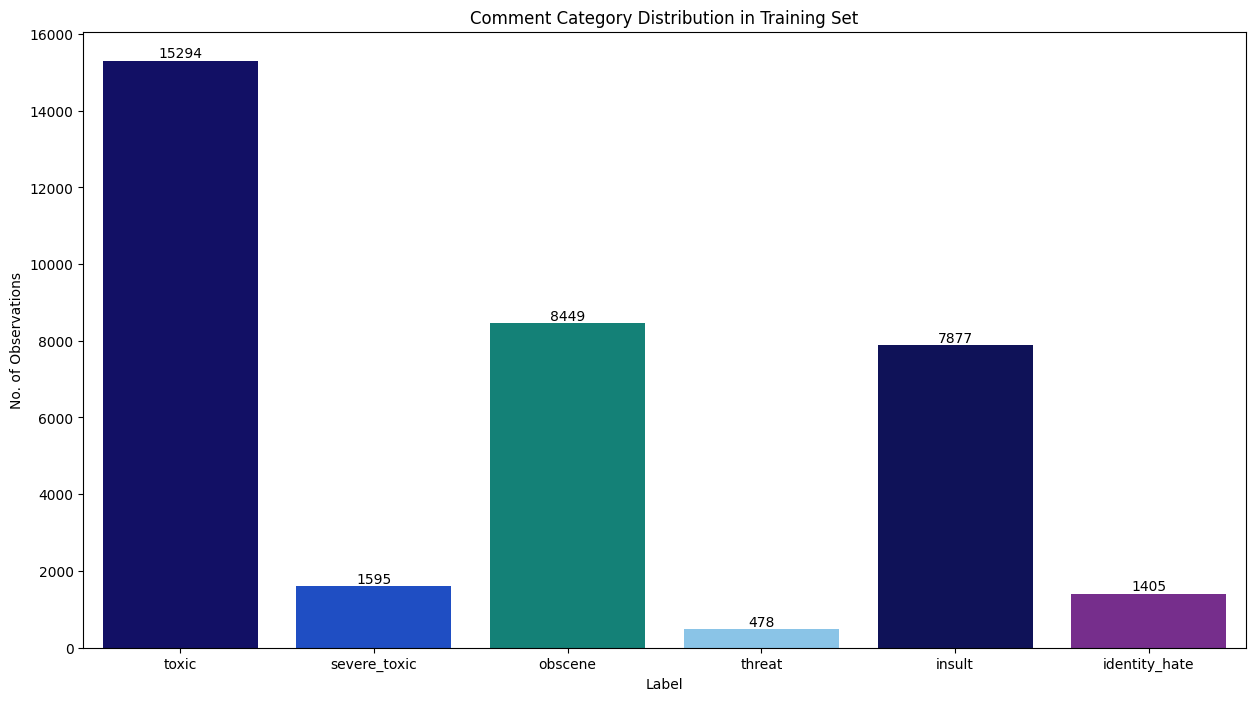

In [3]:
# plot the category distribution
colors_ = ["deep blue","blue","teal","lightblue","darkblue","purple"]
palette = sns.xkcd_palette(colors_)

x = processed_df.iloc[:,2:8].sum()

plt.figure(figsize=(15,8))
ax = sns.barplot(x=x.index, y=x.values, palette=palette)
plt.title("Comment Category Distribution in Training Set")
plt.xlabel('Label')
plt.ylabel('No. of Observations')

patch = ax.patches
labels = x.values
for rect, label in zip(patch, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, va='bottom',ha='center')

plt.show()

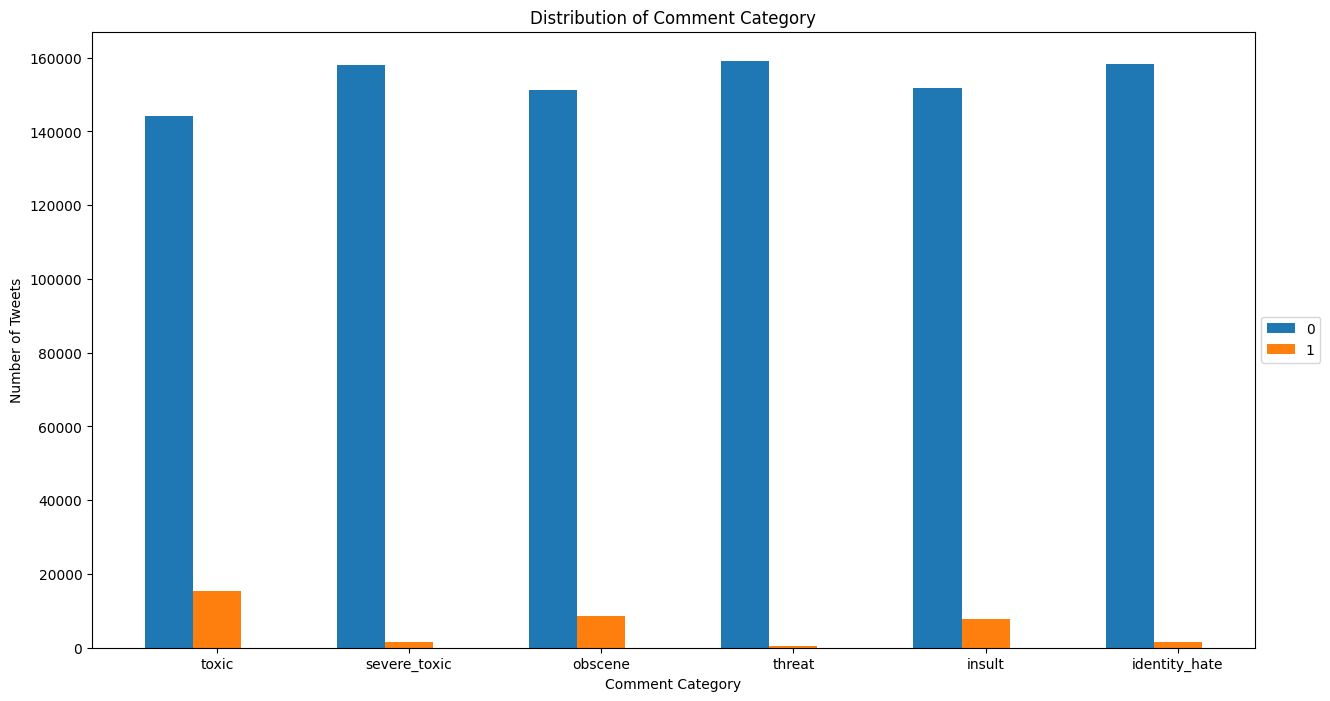

In [4]:
# obtain counts of each class
counts = {
    '0': [],
    '1': [],
}

categories = list(processed_df.columns.values)
categories = categories[2:8]

for c in categories:
    count_occurence_1 = len(processed_df.loc[processed_df[c] == 1])
    count_occurence_0 = len(processed_df.loc[processed_df[c] == 0])
    counts['0'].append(count_occurence_0)
    counts['1'].append(count_occurence_1)

# Plot distribution of comment category
x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15,8))

for attribute, measurement in counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Tweets')
ax.set_xlabel('Comment Category')
ax.set_title('Distribution of Comment Category')
ax.set_xticks(x + width)
ax.set_xticklabels(categories)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Total number of comments =  159571
Number of non-toxic comments =  143346
Number of comments with toxic labels = 16225
89.832 % percentage of rows contains only zeros in training data


[Text(0.5, 1.0, 'Toxic vs Non-Toxic Tweets Distribution')]

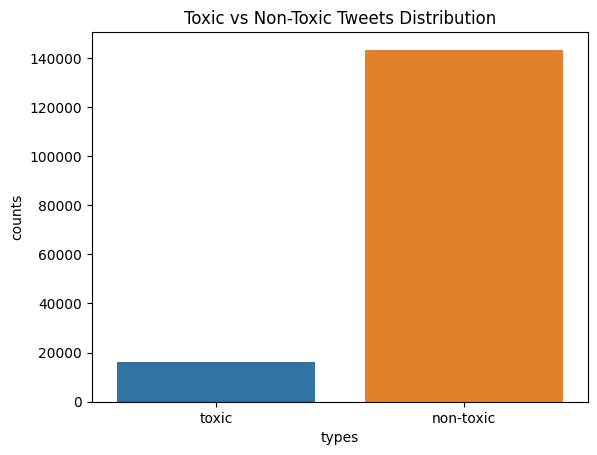

In [5]:
toxic_comments_count= len(processed_df[processed_df[categories].sum(axis=1) > 0])
nontoxic_comments_count = len(processed_df[processed_df[categories].sum(axis=1) == 0])

print("Total number of comments = ",len(processed_df))
print("Number of non-toxic comments = ",nontoxic_comments_count)
print("Number of comments with toxic labels =",(len(processed_df)-nontoxic_comments_count))

print(f"{round(nontoxic_comments_count/len(processed_df) * 100,3)} % percentage of rows contains only zeros in training data")

count = pd.DataFrame(dict(
    types = ['toxic', 'non-toxic'],
    counts = [toxic_comments_count, nontoxic_comments_count]
))

sns.barplot(data=count, x='types',y='counts').set(title='Toxic vs Non-Toxic Tweets Distribution')

The data is highly imbalanced. Strategies need to be adopted to increase the representability of minority class.

## Length-related Exploration

In [6]:
# no punctuations version is used
length_df = processed_df[['id','toxic','severe_toxic','obscene','threat','insult','identity_hate','text_tokenized_nopunc']].copy()

### Comment Length in Words Distribution

In [7]:
length_df['length_words'] = length_df['text_tokenized_nopunc'].apply(len)

In [8]:
length_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_tokenized_nopunc,length_words
0,0000997932d777bf,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my...",48
1,000103f0d9cfb60f,0,0,0,0,0,0,"[daww, he, matches, this, background, colour, ...",18
2,000113f07ec002fd,0,0,0,0,0,0,"[hey, man, i, am, really, not, trying, to, edi...",44
3,0001b41b1c6bb37e,0,0,0,0,0,0,"[more, i, cannot, make, any, real, suggestions...",110
4,0001d958c54c6e35,0,0,0,0,0,0,"[you, sir, are, my, hero, any, chance, you, re...",14


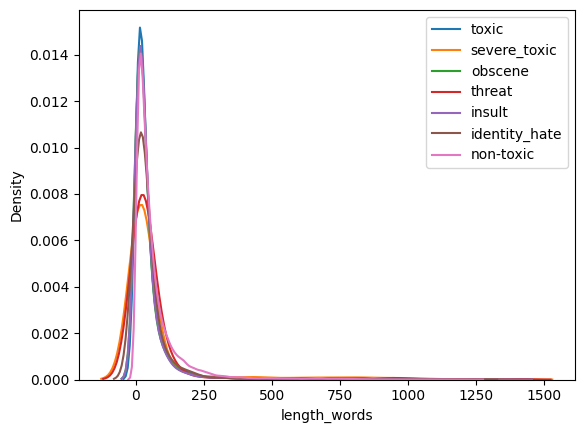

In [9]:
# plot the result of embeddings
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for label in labels:
    length_words = length_df[length_df[label]==1].length_words
    sns.kdeplot(length_words, label=label)
length_words = length_df[length_df[labels].sum(axis=1)==0].length_words
sns.kdeplot(length_words, label='non-toxic')
plt.legend()
plt.show()

### Comment Length in Characters Distribution

In [10]:
length_df['length_chars'] = length_df['text_tokenized_nopunc'].apply(lambda x: ''.join(word for word in x)).apply(lambda x: len(x))

In [11]:
length_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_tokenized_nopunc,length_words,length_chars
0,0000997932d777bf,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my...",48,215
1,000103f0d9cfb60f,0,0,0,0,0,0,"[daww, he, matches, this, background, colour, ...",18,84
2,000113f07ec002fd,0,0,0,0,0,0,"[hey, man, i, am, really, not, trying, to, edi...",44,188
3,0001b41b1c6bb37e,0,0,0,0,0,0,"[more, i, cannot, make, any, real, suggestions...",110,489
4,0001d958c54c6e35,0,0,0,0,0,0,"[you, sir, are, my, hero, any, chance, you, re...",14,51


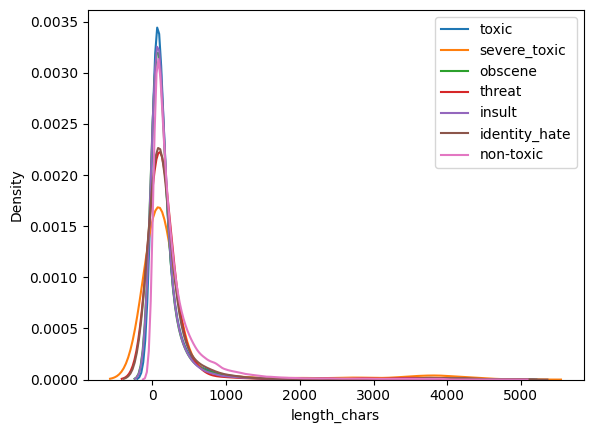

In [12]:
# plot the result of embeddings
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for label in labels:
    length_chars = length_df[length_df[label]==1].length_chars
    sns.kdeplot(length_chars, label=label)
length_chars = length_df[length_df[labels].sum(axis=1)==0].length_chars
sns.kdeplot(length_chars, label='non-toxic')
plt.legend()
plt.show()

### Average Word Length

In [13]:
length_df['avg_word_len'] = length_df['length_chars']/length_df['length_words']

In [14]:
length_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_tokenized_nopunc,length_words,length_chars,avg_word_len
0,0000997932d777bf,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my...",48,215,4.479167
1,000103f0d9cfb60f,0,0,0,0,0,0,"[daww, he, matches, this, background, colour, ...",18,84,4.666667
2,000113f07ec002fd,0,0,0,0,0,0,"[hey, man, i, am, really, not, trying, to, edi...",44,188,4.272727
3,0001b41b1c6bb37e,0,0,0,0,0,0,"[more, i, cannot, make, any, real, suggestions...",110,489,4.445455
4,0001d958c54c6e35,0,0,0,0,0,0,"[you, sir, are, my, hero, any, chance, you, re...",14,51,3.642857


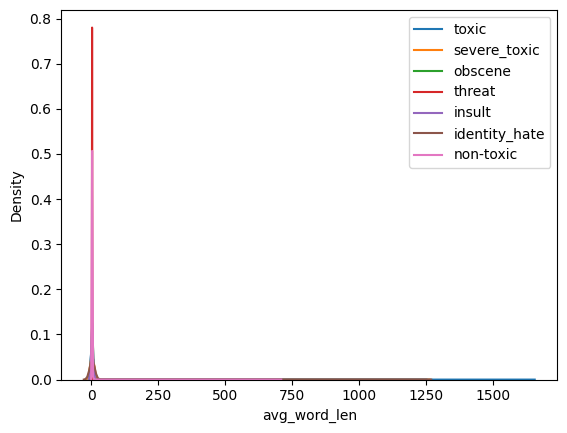

In [17]:
# plot the result of embeddings
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for label in labels:
    avg_word_len = length_df[length_df[label]==1].avg_word_len
    sns.kdeplot(avg_word_len, label=label)
avg_word_len = length_df[length_df[labels].sum(axis=1)==0].avg_word_len
sns.kdeplot(avg_word_len, label='non-toxic')
plt.legend()
plt.show()

## Top Frequent Tags and Associated Words

### Overall Data

In [44]:
# count the occurrence of tags
POS_list = processed_df['POS_tagging_flat'].tolist()
POS_count = Counter(chain(*POS_list))

In [45]:
POS_frequent_df = pd.DataFrame.from_dict(POS_count, orient='index').reset_index()
POS_frequent_df.columns = ['POS_tags', 'Count']
POS_frequent_df = POS_frequent_df.sort_values(by=['Count'], ascending=False)
POS_frequent_df['Word'] = POS_frequent_df['POS_tags'].apply(lambda x: x[0])
POS_frequent_df['Tag'] = POS_frequent_df['POS_tags'].apply(lambda x: x[1])
POS_frequent_df

,POS_tags,Count,Word,Tag
31,"(., .)",546890,.,.
2,"(the, DT)",496923,the,DT
17,"(,, ,)",459284,",",","
69,"(to, TO)",298571,to,TO
84,"(of, IN)",224336,of,IN
...,...,...,...,...
161871,"(n3gros, JJ)",1,n3gros,JJ
161872,"(areaseven, JJ)",1,areaseven,JJ
161874,"(chaged, VBN)",1,chaged,VBN
161875,"(managua, VB)",1,managua,VB


In [46]:
# stop words
stop_words = stopwords.words('english')
# punctuations
list_punctuations = []
punctuations = string.punctuation 
for x in punctuations:
    list_punctuations.append(x)

# remove stop words and punctuations
POS_frequent_df = POS_frequent_df.query("Word not in @stop_words & Word not in @list_punctuations")
POS_frequent_df

,POS_tags,Count,Word,Tag
189,"(article, NN)",55654,article,NN
39,"(page, NN)",45342,page,NN
208,"(would, MD)",36234,would,MD
38,"(talk, NN)",33105,talk,NN
162,"(wikipedia, NN)",31631,wikipedia,NN
...,...,...,...,...
161871,"(n3gros, JJ)",1,n3gros,JJ
161872,"(areaseven, JJ)",1,areaseven,JJ
161874,"(chaged, VBN)",1,chaged,VBN
161875,"(managua, VB)",1,managua,VB


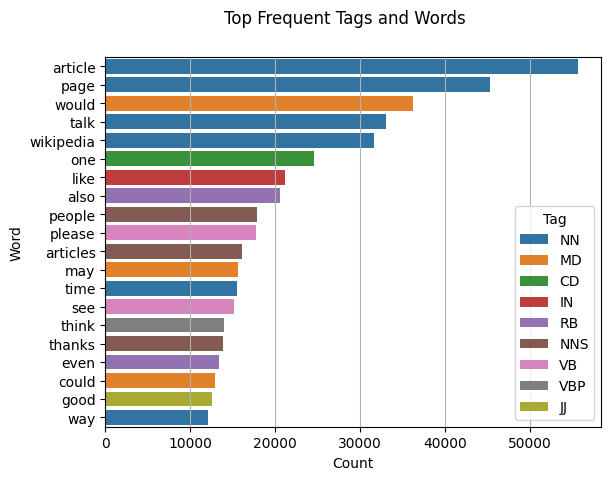

In [47]:
fig, ax = plt.subplots()
fig.suptitle("Top Frequent Tags and Words", fontsize=12)
sns.barplot(x='Count', y='Word', hue='Tag', 
            data=POS_frequent_df.iloc[:20,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.show()

The top frequent tags and words for all comments are common ones.

### Toxic Comments Data

In [48]:
# count the occurrence of tags in toxic comments
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
toxic_POS_list = processed_df[processed_df[labels].sum(axis=1)>0].POS_tagging_flat.tolist()
toxic_POS_count = Counter(chain(*toxic_POS_list))

In [49]:
toxic_POS_frequent_df = pd.DataFrame.from_dict(toxic_POS_count, orient='index').reset_index()
toxic_POS_frequent_df.columns = ['toxic_POS_tags', 'Count']
toxic_POS_frequent_df = toxic_POS_frequent_df.sort_values(by=['Count'], ascending=False)
toxic_POS_frequent_df['Word'] = toxic_POS_frequent_df['toxic_POS_tags'].apply(lambda x: x[0])
toxic_POS_frequent_df['Tag'] = toxic_POS_frequent_df['toxic_POS_tags'].apply(lambda x: x[1])

In [50]:
toxic_POS_frequent_df = toxic_POS_frequent_df.query("Word not in @stop_words & Word not in @list_punctuations")
toxic_POS_frequent_df

,toxic_POS_tags,Count,Word,Tag
238,"(fuck, NN)",4604,fuck,NN
322,"(like, IN)",3401,like,IN
285,"(wikipedia, NN)",2855,wikipedia,NN
106,"(go, VB)",2494,go,VB
153,"(ass, NN)",2464,ass,NN
...,...,...,...,...
28207,"(foo, NNS)",1,foo,NNS
1258,"(til, VB)",1,til,VB
28195,"(narrow, VB)",1,narrow,VB
28193,"(pre-existing, JJ)",1,pre-existing,JJ


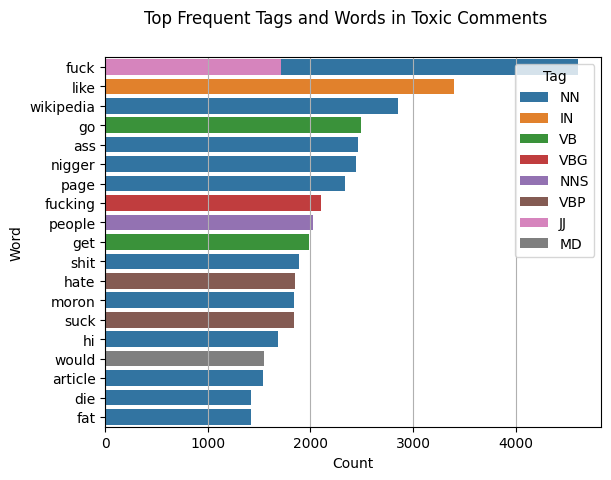

In [51]:
fig, ax = plt.subplots()
fig.suptitle("Top Frequent Tags and Words in Toxic Comments", fontsize=12)
sns.barplot(x='Count', y='Word', hue='Tag', 
            data=toxic_POS_frequent_df.iloc[:20,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.show()

There are some bad words, such as fuck, ass, nigger..., appear very often in the toxic comments. Therefore, the appearance of bad words could be an indicator of toxic comments.

### Non-Toxic Comments Data

In [52]:
# count the occurrence of tags in non-toxic comments
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
nontoxic_POS_list = processed_df[processed_df[labels].sum(axis=1)==0].POS_tagging_flat.tolist()
nontoxic_POS_count = Counter(chain(*nontoxic_POS_list))

In [53]:
nontoxic_POS_frequent_df = pd.DataFrame.from_dict(nontoxic_POS_count, orient='index').reset_index()
nontoxic_POS_frequent_df.columns = ['nontoxic_POS_tags', 'Count']
nontoxic_POS_frequent_df = nontoxic_POS_frequent_df.sort_values(by=['Count'], ascending=False)
nontoxic_POS_frequent_df['Word'] = nontoxic_POS_frequent_df['nontoxic_POS_tags'].apply(lambda x: x[0])
nontoxic_POS_frequent_df['Tag'] = nontoxic_POS_frequent_df['nontoxic_POS_tags'].apply(lambda x: x[1])

In [54]:
nontoxic_POS_frequent_df = nontoxic_POS_frequent_df.query("Word not in @stop_words & Word not in @list_punctuations")
nontoxic_POS_frequent_df

,nontoxic_POS_tags,Count,Word,Tag
184,"(article, NN)",54112,article,NN
39,"(page, NN)",43006,page,NN
203,"(would, MD)",34686,would,MD
38,"(talk, NN)",31806,talk,NN
162,"(wikipedia, NN)",28776,wikipedia,NN
...,...,...,...,...
152736,"(invasive, NN)",1,invasive,NN
152737,"(stroganoff, NN)",1,stroganoff,NN
152738,"(not-so-large, NN)",1,not-so-large,NN
152742,"(myskin, NN)",1,myskin,NN


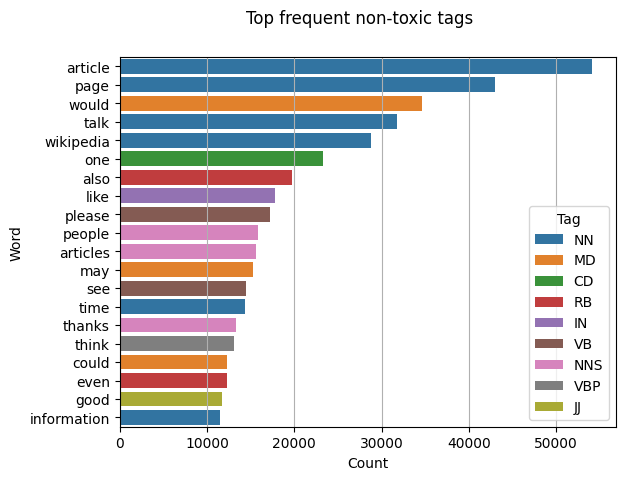

In [55]:
fig, ax = plt.subplots()
fig.suptitle("Top frequent non-toxic tags", fontsize=12)
sns.barplot(x='Count', y='Word', hue='Tag', 
            data=nontoxic_POS_frequent_df.iloc[:20,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.show()

Again, the top frequent tags and words for non-toxic comments are common ones.

### Frequent Words Identification

In [38]:
def most_frequent_words(text):
    words = word_tokenize(text)
    fdist = FreqDist(words) 
    
    df_fdist = pd.DataFrame({'Word': fdist.keys(),
                             'Frequency': fdist.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)
    # return the top 50 frequent words
    return df_fdist.head(50)

In [52]:
# remove stop words in lemmatization results
stop_words = stopwords.words('english')
processed_df['lemmatization_nostop'] = processed_df['lemmatization'].apply(lambda x: [i for i in x if i not in stop_words])

In [54]:
processed_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,text_tokenized,text_tokenized_nopunc,POS_tagging,POS_tagging_flat,lemmatization,lemmatization_nostop
0,0000997932d777bf,0,0,0,0,0,0,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my...","[explanation, why, the, edits, made, under, my...","[[(explanation, NN), (why, WRB), (the, DT), (e...","[(explanation, NN), (why, WRB), (the, DT), (ed...","[explanation, edits, made, username, hardcore,...","[explanation, edits, made, username, hardcore,..."
1,000103f0d9cfb60f,0,0,0,0,0,0,d'aww! he matches this background colour i am ...,"[d'aww, !, he, matches, this, background, colo...","[daww, he, matches, this, background, colour, ...","[[(d'aww, NN), (!, .)], [(he, PRP), (matches, ...","[(d'aww, NN), (!, .), (he, PRP), (matches, VBZ...","[d'aww, match, colour, i, am, seemingly, stuck...","[d'aww, match, colour, seemingly, stuck, thank..."
2,000113f07ec002fd,0,0,0,0,0,0,"hey man, i am really not trying to edit war. i...","[hey, man, ,, i, am, really, not, trying, to, ...","[hey, man, i, am, really, not, trying, to, edi...","[[(hey, NN), (man, NN), (,, ,), (i, JJ), (am, ...","[(hey, NN), (man, NN), (,, ,), (i, JJ), (am, V...","[hey, man, i, am, really, not, trying, edit, w...","[hey, man, really, trying, edit, war, guy, con..."
3,0001b41b1c6bb37e,0,0,0,0,0,0,""" more i cannot make any real suggestions on i...","["", more, i, cannot, make, any, real, suggesti...","[more, i, cannot, make, any, real, suggestions...","[[("", IN), (more, JJR), (i, JJ), (cannot, NNS)...","[("", IN), (more, JJR), (i, JJ), (cannot, NNS),...","[more, i, cannot, make, real, suggestion, impr...","[cannot, make, real, suggestion, improvement, ..."
4,0001d958c54c6e35,0,0,0,0,0,0,"you, sir, are my hero. any chance you remember...","[you, ,, sir, ,, are, my, hero, ., any, chance...","[you, sir, are, my, hero, any, chance, you, re...","[[(you, PRP), (,, ,), (sir, VB), (,, ,), (are,...","[(you, PRP), (,, ,), (sir, VB), (,, ,), (are, ...","[sir, are, hero, chance, remember, page, is]","[sir, hero, chance, remember, page]"


In [44]:
#identify frequent words in toxic comments
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
combined_toxic = processed_df[processed_df[labels].sum(axis=1)>0].lemmatization_nostop.str.join(' ')
combined_toxic = ' '.join(combined_toxic)
toxic_frequent = most_frequent_words(combined_toxic)

In [45]:
#identify frequent words in non-toxic comments
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
combined_nontoxic = processed_df[processed_df[labels].sum(axis=1)==0].lemmatization_nostop.str.join(' ')
combined_nontoxic = ' '.join(combined_nontoxic)
nontoxic_frequent = most_frequent_words(combined_nontoxic)

In [60]:
#identify frequent words in each type of toxic comments
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
toxic_frequent_list = []
for label in labels:
    combined_toxic = processed_df[processed_df[label]==1].lemmatization_nostop.str.join(' ')
    combined_toxic =  ' '.join(combined_toxic)
    toxic_frequent = most_frequent_words(combined_toxic)
    toxic_frequent_list.append(toxic_frequent)

In [46]:
toxic_frequent.head()

,Word,Frequency
88,fuck,9673
794,suck,4686
119,shit,3670
184,wikipedia,3545
460,nigger,3420


Comparing the most frequent words in each toxic comment categories with a bad word list (https://www.kaggle.com/datasets/nicapotato/bad-bad-words) to identify the bad words used.

In [66]:
bad_words = pd.read_csv('Data/bad-words.csv', header=None)

In [67]:
bad_words.head()

,0
0,jigaboo
1,mound of venus
2,asslover
3,s&m
4,queaf


In [71]:
bad_words_list = list(bad_words[0])

In [86]:
bad_words_df = pd.DataFrame({'Words':[], 'Category':[]})
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i in range(len(toxic_frequent_list)):
    frequent_bad_words = set(bad_words_list).intersection(set(toxic_frequent_list[i].Word))
    category_df = pd.DataFrame({'Words': list(frequent_bad_words), 'Category': [labels[i]]*len(frequent_bad_words)})
    bad_words_df = pd.concat([bad_words_df, category_df])

In [89]:
bad_words_df

,Words,Category
0,dick,toxic
1,wanker,toxic
2,die,toxic
3,cock,toxic
4,gay,toxic
...,...,...
14,stupid,identity_hate
15,shit,identity_hate
16,kill,identity_hate
17,fuck,identity_hate


In [90]:
bad_words_df.to_csv('Data/frequent_bad_words.csv', index=False)

In [47]:
nontoxic_frequent.head()

,Word,Frequency
81,article,71682
109,wa,53925
20,page,53780
90,wikipedia,41434
19,talk,35472


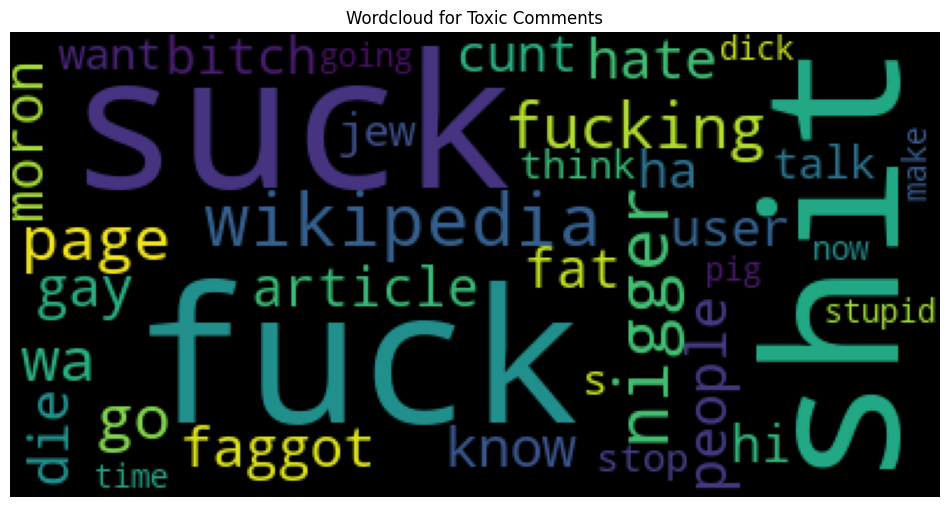

In [68]:
# visualize wordcloud for toxic comments
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(toxic_frequent['Word']))
plt.imshow(word_cloud)
plt.axis('off')
plt.title("Wordcloud for Toxic Comments")
plt.show()

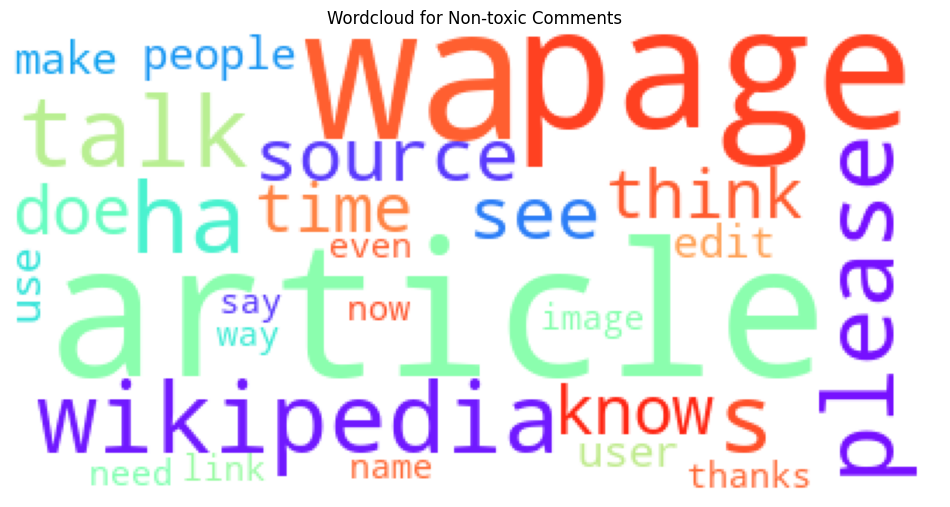

In [69]:
# visualize wordcloud for non-toxic comments
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='white',
                          max_font_size = 80,
                          colormap='rainbow'
                         ).generate(" ".join(nontoxic_frequent['Word']))
plt.imshow(word_cloud)
plt.title("Wordcloud for Non-toxic Comments")
plt.axis('off')
plt.show()

Again, it shows that the frequent words differ between toxic and non-toxic comments.

## Weighted Words - Bag of Words (BoW) - Bag of n-grams

### Frequency Vector

In [72]:
# bigrams frequency
vec = CountVectorizer(ngram_range=(2, 2))
bow = vec.fit_transform(processed_df['text_tokenized'].str.join(' '))
sum_of_words = bow.sum(axis=0)
bigrams_freq = [(word, sum_of_words[0, idx]) for word, idx in vec.vocabulary_.items()]
bigrams_freq =sorted(bigrams_freq, key = lambda x: x[1], reverse=True)
bigrams_freq = pd.DataFrame(bigrams_freq[:50], columns=["bigrams", "frequency"])

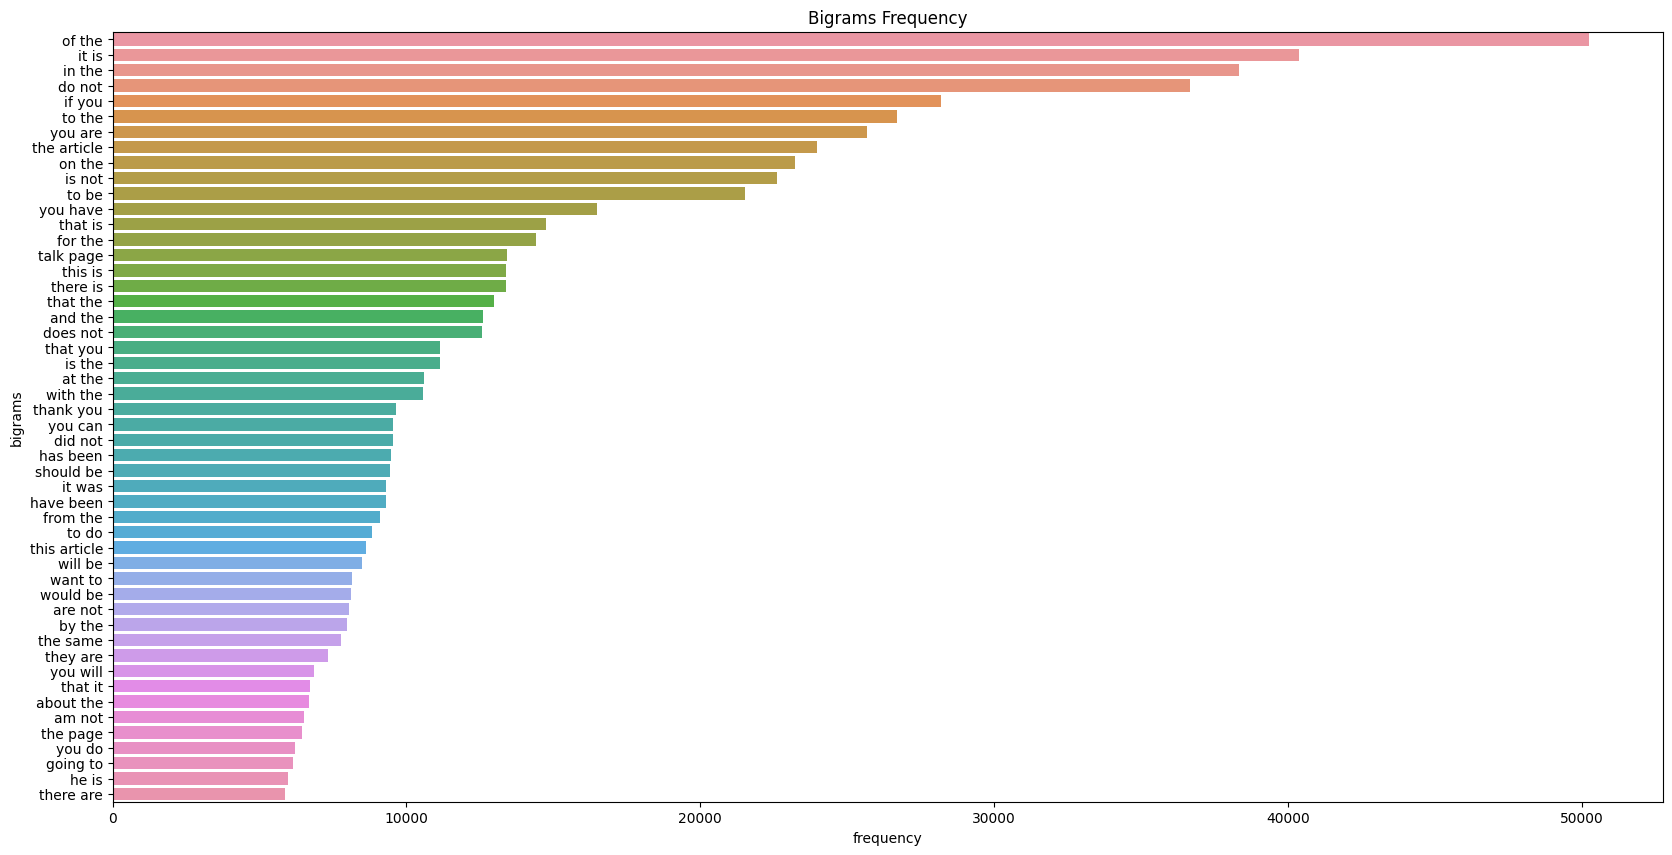

In [74]:
plt.figure(figsize=(20,10))
sns.barplot(data = bigrams_freq, x = "frequency", y="bigrams")
plt.title("Bigrams Frequency")
plt.show()

In [75]:
# trigrams frequency
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(processed_df['text_tokenized'].str.join(' '))
sum_of_words = bow.sum(axis=0)
trigrams_freq = [(word, sum_of_words[0, idx]) for word, idx in vec.vocabulary_.items()]
trigrams_freq =sorted(trigrams_freq, key = lambda x: x[1], reverse=True)
trigrams_freq = pd.DataFrame(trigrams_freq[:50], columns=["trigrams", "frequency"])

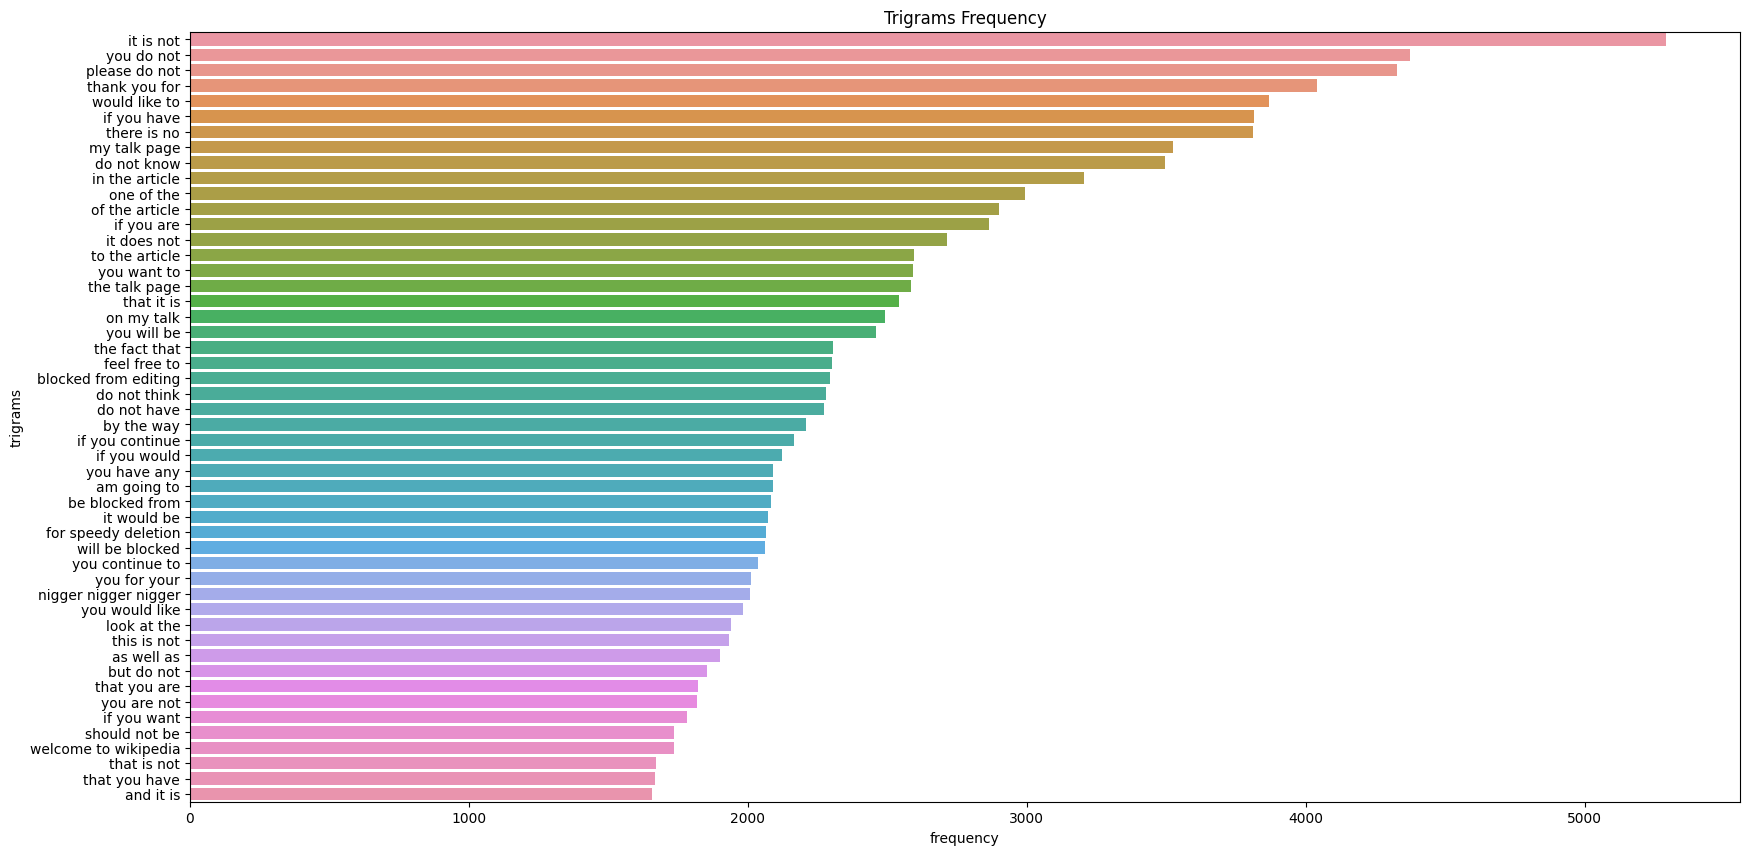

In [76]:
plt.figure(figsize=(20,10))
sns.barplot(data = trigrams_freq, x = "frequency", y="trigrams")
plt.title("Trigrams Frequency")
plt.show()

### Term Frequency-Inverse Document Frequency (TF-IDF)

Term frequency-inverse document frequency may be a better measure of frequency, as it give more weights to the less frequent words.

In [77]:
# bigrams frequency
tfidf =  TfidfVectorizer(ngram_range=(2, 2))
bow = tfidf.fit_transform(processed_df['text_tokenized'].str.join(' '))
sum_of_words = bow.sum(axis=0)
bigrams_freq = [(word, sum_of_words[0, idx]) for word, idx in tfidf.vocabulary_.items()]
bigrams_freq =sorted(bigrams_freq, key = lambda x: x[1], reverse=True)
bigrams_freq = pd.DataFrame(bigrams_freq[:50], columns=["bigrams", "frequency"])

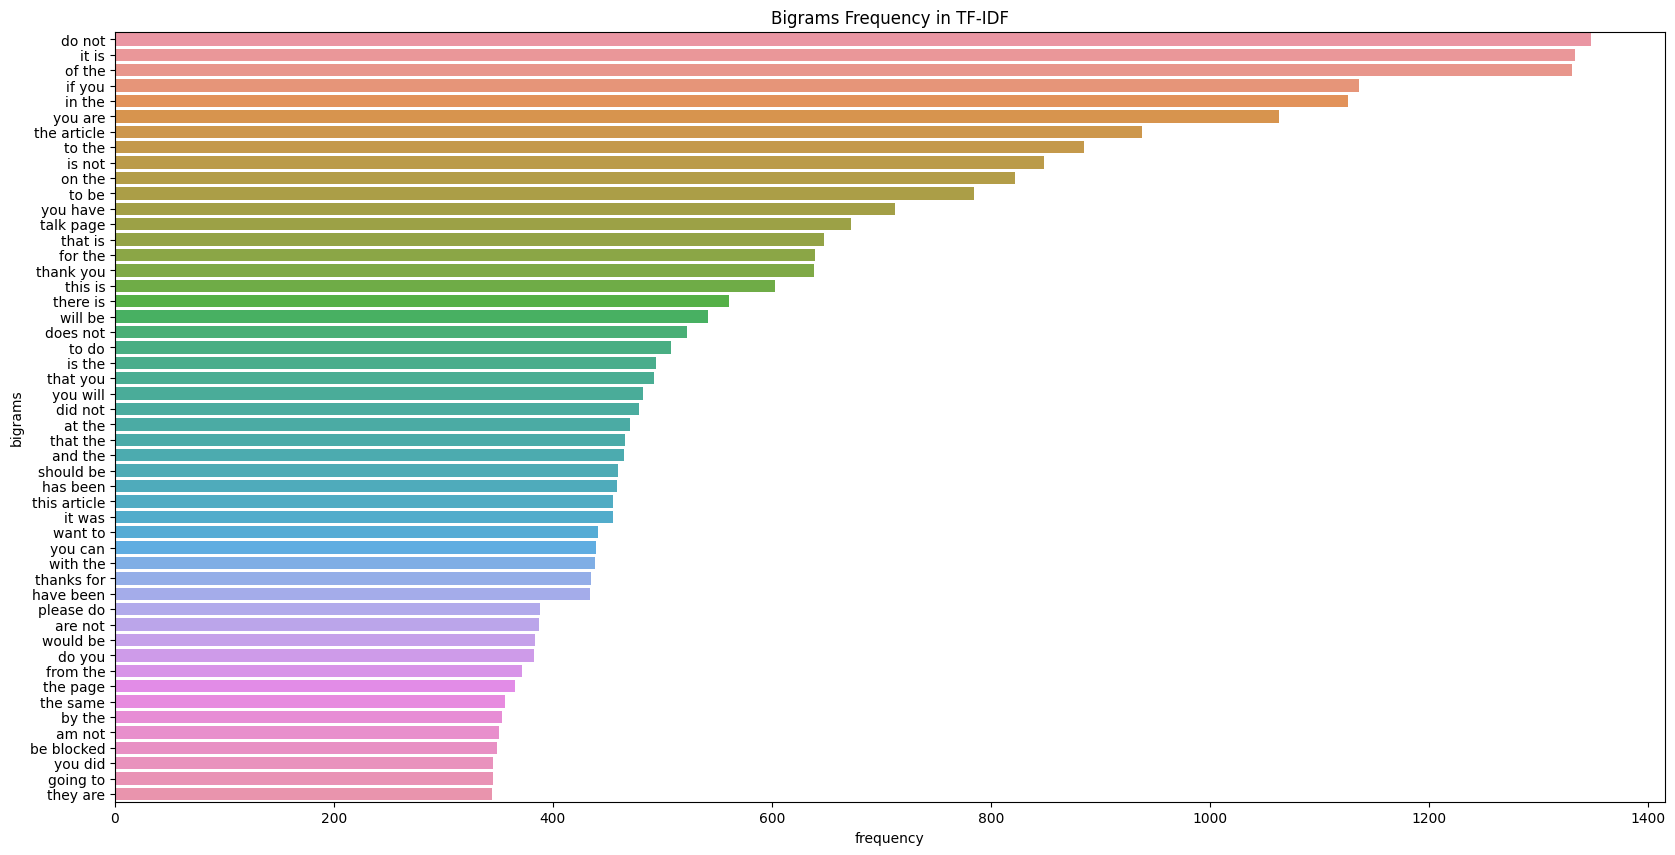

In [93]:
plt.figure(figsize=(20,10))
sns.barplot(data = bigrams_freq, x = "frequency", y="bigrams")
plt.title("Bigrams Frequency in TF-IDF")
plt.show()

In [95]:
# bigrams frequency of toxic comments
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
processed_df_toxic = processed_df[processed_df[labels].sum(axis=1)>0]

tfidf =  TfidfVectorizer(ngram_range=(2, 2))
bow_toxic = tfidf.fit_transform(processed_df_toxic['text_tokenized'].str.join(' '))
sum_of_words_toxic = bow_toxic.sum(axis=0)
bigrams_freq_toxic = [(word, sum_of_words_toxic[0, idx]) for word, idx in tfidf.vocabulary_.items()]
bigrams_freq_toxic =sorted(bigrams_freq_toxic, key = lambda x: x[1], reverse=True)
bigrams_freq_toxic = pd.DataFrame(bigrams_freq_toxic[:50], columns=["bigrams", "frequency"])

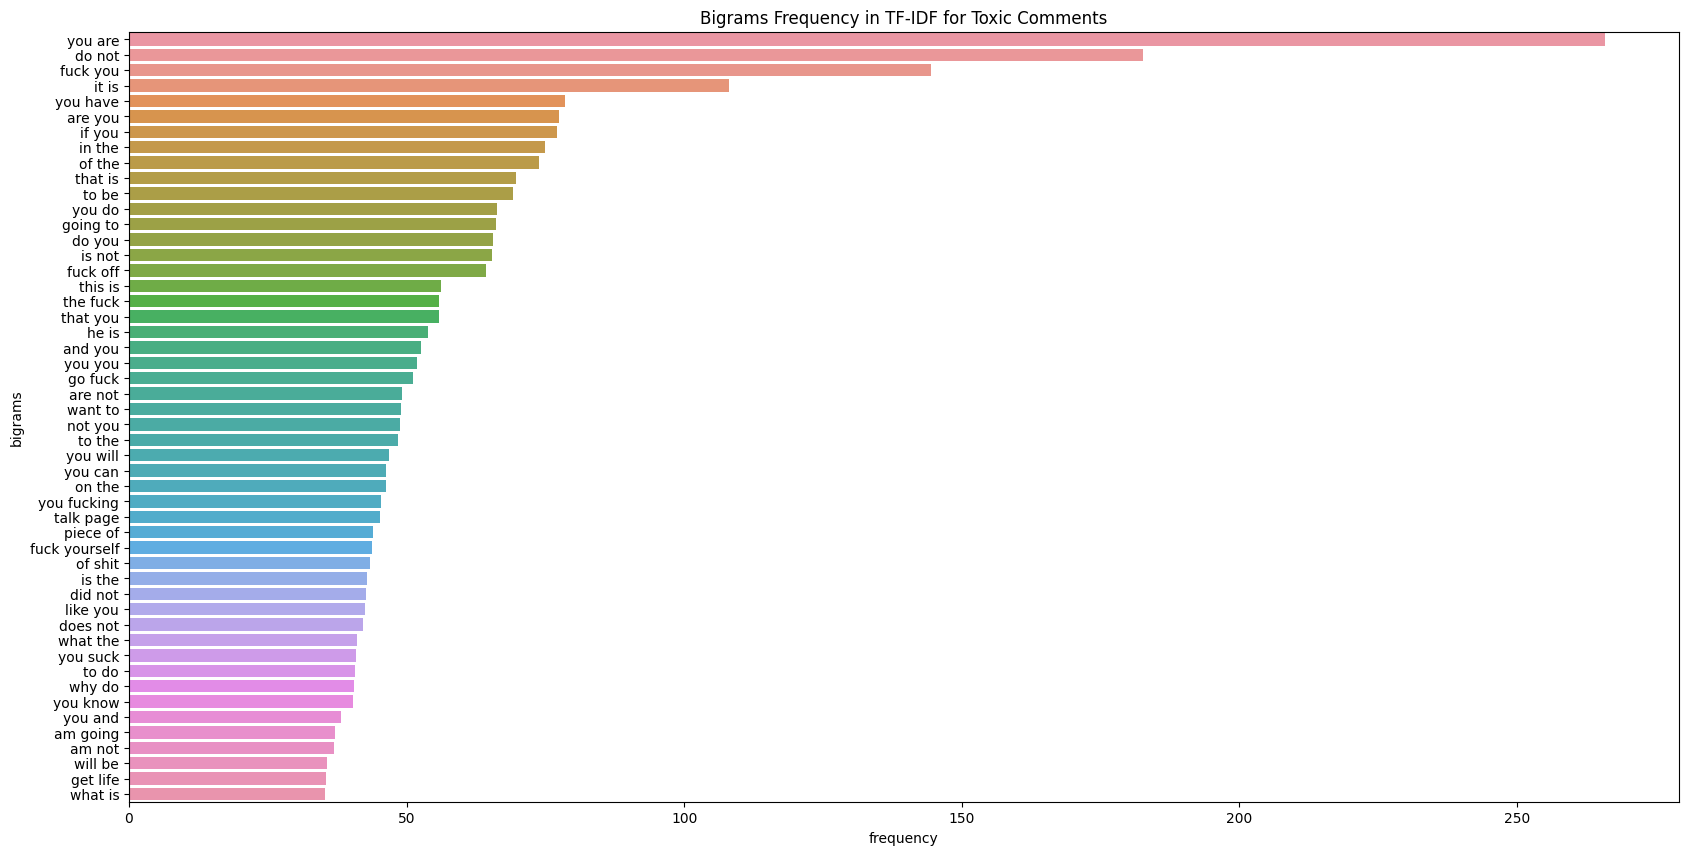

In [96]:
plt.figure(figsize=(20,10))
sns.barplot(data = bigrams_freq_toxic, x = "frequency", y="bigrams")
plt.title("Bigrams Frequency in TF-IDF for Toxic Comments")
plt.show()

In [79]:
# trigrams frequency
tfidf =  TfidfVectorizer(ngram_range=(3, 3))
bow = tfidf.fit_transform(processed_df['text_tokenized'].str.join(' '))
sum_of_words = bow.sum(axis=0)
trigrams_freq = [(word, sum_of_words[0, idx]) for word, idx in tfidf.vocabulary_.items()]
trigrams_freq =sorted(trigrams_freq, key = lambda x: x[1], reverse=True)
trigrams_freq = pd.DataFrame(trigrams_freq[:50], columns=["trigrams", "frequency"])

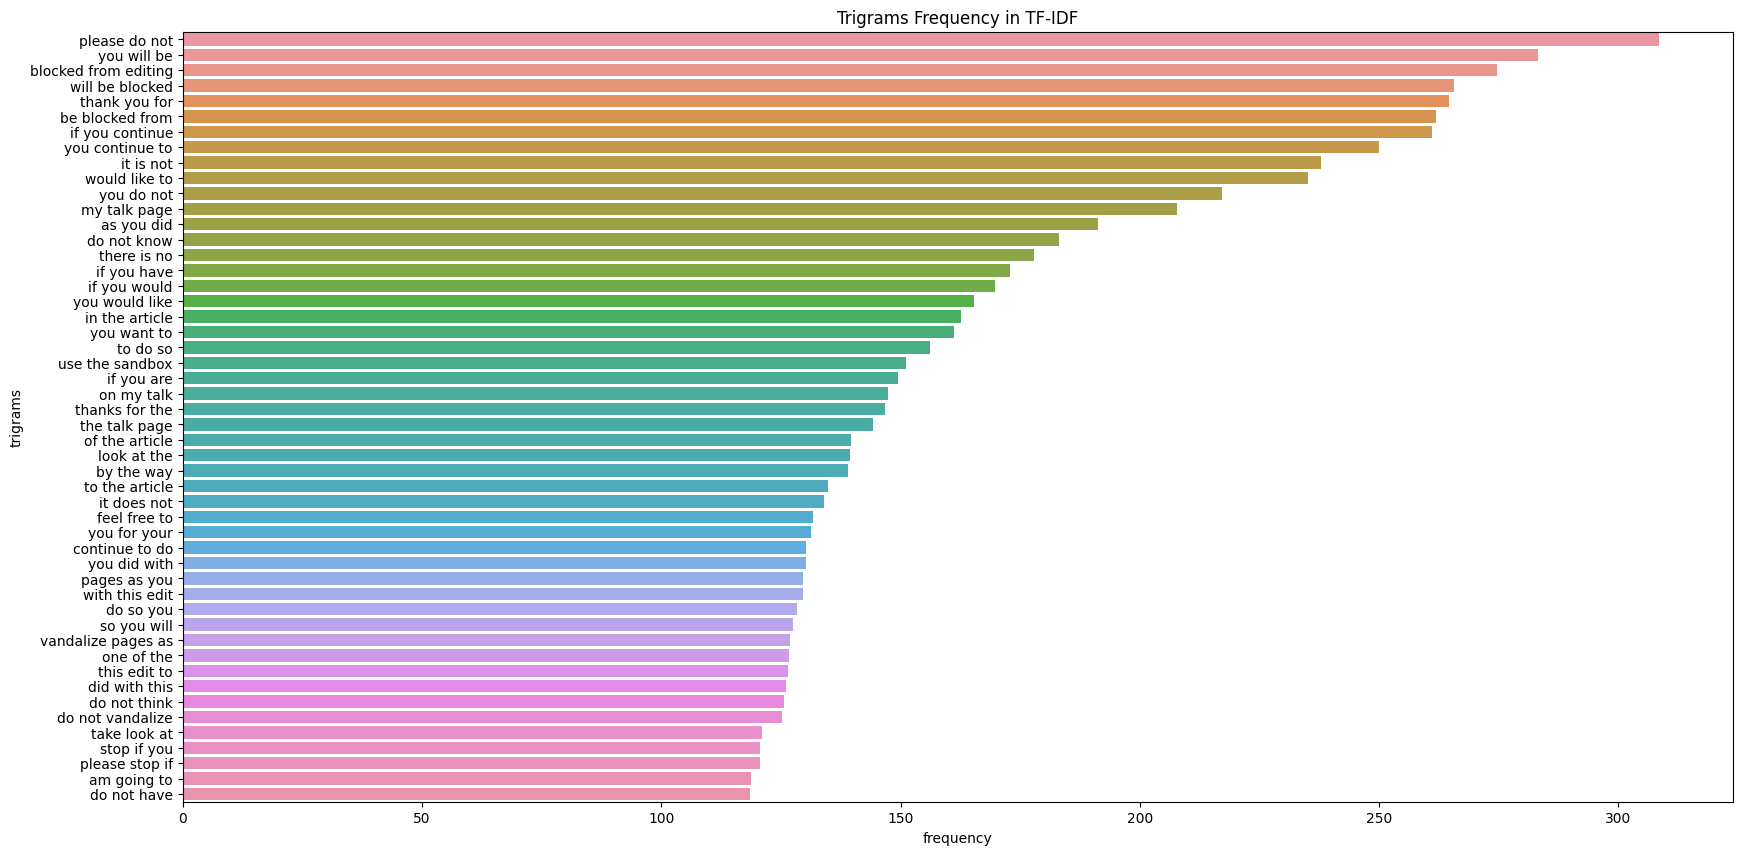

In [94]:
plt.figure(figsize=(20,10))
sns.barplot(data = trigrams_freq, x = "frequency", y="trigrams")
plt.title("Trigrams Frequency in TF-IDF")
plt.show()

In [97]:
# trigrams frequency of toxic comments
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
processed_df_toxic = processed_df[processed_df[labels].sum(axis=1)>0]

tfidf =  TfidfVectorizer(ngram_range=(3, 3))
bow_toxic = tfidf.fit_transform(processed_df_toxic['text_tokenized'].str.join(' '))
sum_of_words_toxic = bow_toxic.sum(axis=0)
trigrams_freq_toxic = [(word, sum_of_words_toxic[0, idx]) for word, idx in tfidf.vocabulary_.items()]
trigrams_freq_toxic =sorted(trigrams_freq_toxic, key = lambda x: x[1], reverse=True)
trigrams_freq_toxic = pd.DataFrame(trigrams_freq_toxic[:50], columns=["trigrams", "frequency"])

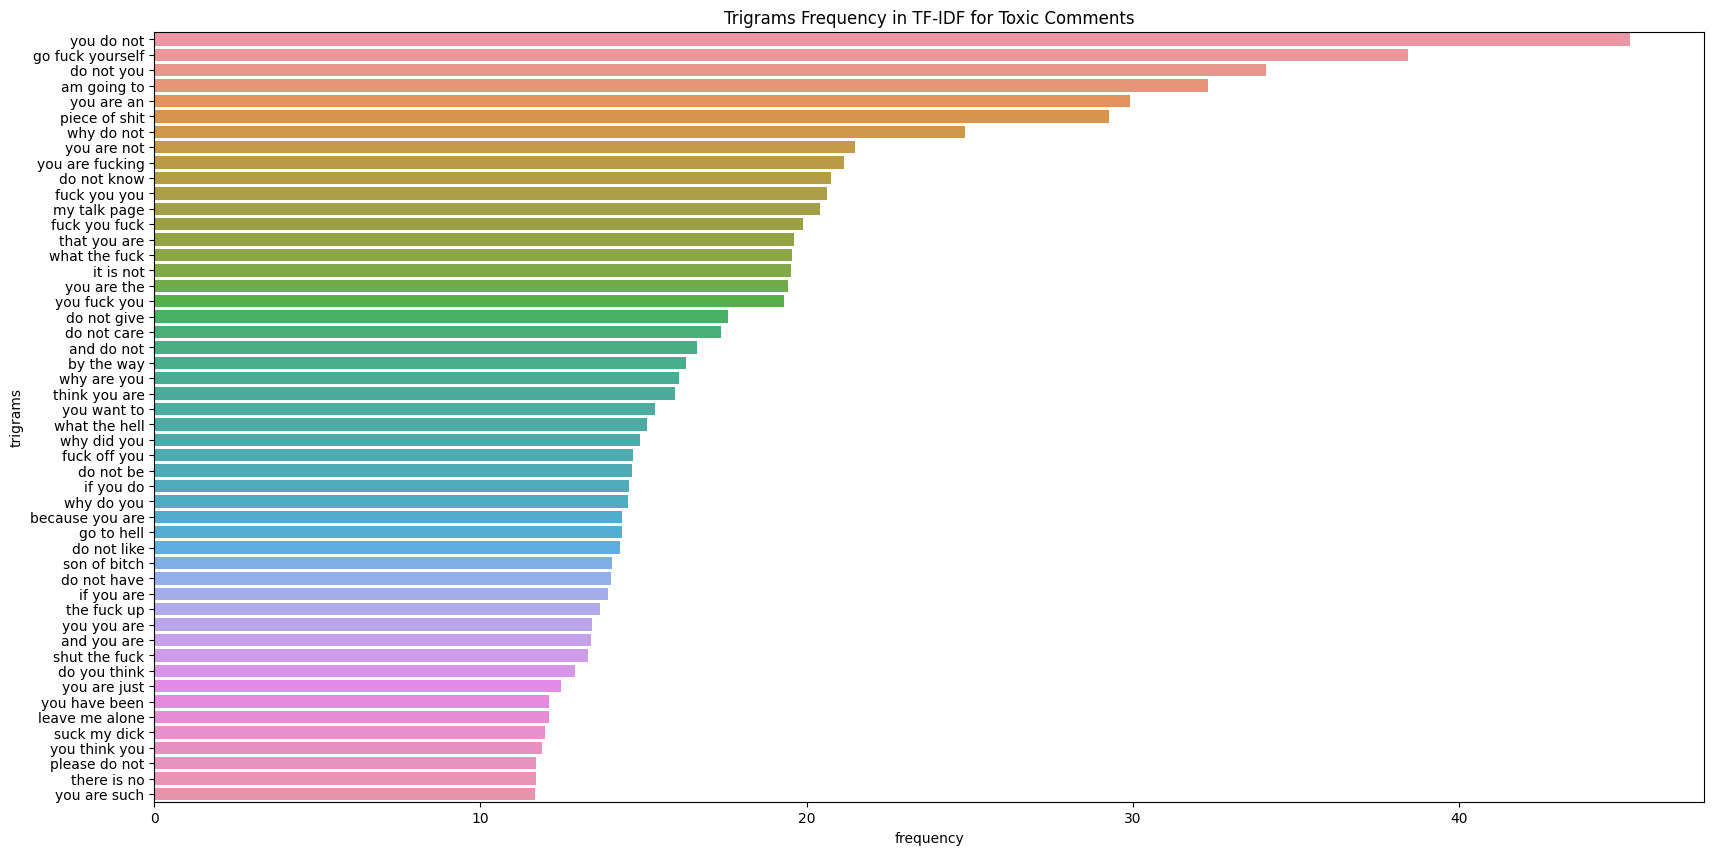

In [99]:
plt.figure(figsize=(20,10))
sns.barplot(data = trigrams_freq_toxic, x = "frequency", y="trigrams")
plt.title("Trigrams Frequency in TF-IDF for Toxic Comments")
plt.show()

As can be seen from the most frequent n-gram words, there are many bad words appearing. These may be good features for us to use in detection of toxic comments.

## Sentiment Analysis

Sentiment analysis, implemented with SentimentIntensityAnalyzer, is applied on the cleaned text.

In [21]:
# calculate VADER score
sentiments = SentimentIntensityAnalyzer()
semtiment_df = processed_df[['id','toxic','severe_toxic','obscene','threat','insult','identity_hate','clean_text']].copy()
sentiment_results = semtiment_df["clean_text"].apply(sentiments.polarity_scores)

In [22]:
semtiment_df["Positive"] = list(map(lambda x: x['pos'], sentiment_results))
semtiment_df["Negative"] = list(map(lambda x: x['neg'], sentiment_results))
semtiment_df["Neutral"] = list(map(lambda x: x['neu'], sentiment_results))
semtiment_df["compound"] = list(map(lambda x: x['compound'], sentiment_results))
semtiment_df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,Positive,Negative,Neutral,compound
0,0000997932d777bf,0,0,0,0,0,0,explanation why the edits made under my userna...,0.099,0.000,0.901,0.5574
1,000103f0d9cfb60f,0,0,0,0,0,0,d'aww! he matches this background colour i am ...,0.158,0.099,0.743,0.2942
2,000113f07ec002fd,0,0,0,0,0,0,"hey man, i am really not trying to edit war. i...",0.067,0.081,0.852,-0.1779
3,0001b41b1c6bb37e,0,0,0,0,0,0,""" more i cannot make any real suggestions on i...",0.062,0.022,0.917,0.5106
4,0001d958c54c6e35,0,0,0,0,0,0,"you, sir, are my hero. any chance you remember...",0.318,0.000,0.682,0.6808
...,...,...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,0,0,0,0,0,0,""":and for the second time of asking, when your...",0.099,0.110,0.791,-0.1414
159567,ffea4adeee384e90,0,0,0,0,0,0,you should be ashamed of yourself that is a ho...,0.000,0.306,0.694,-0.7650
159568,ffee36eab5c267c9,0,0,0,0,0,0,"spitzer umm, there is no actual article for pr...",0.000,0.167,0.833,-0.2960
159569,fff125370e4aaaf3,0,0,0,0,0,0,and it looks like it was actually you who put ...,0.098,0.000,0.902,0.3612


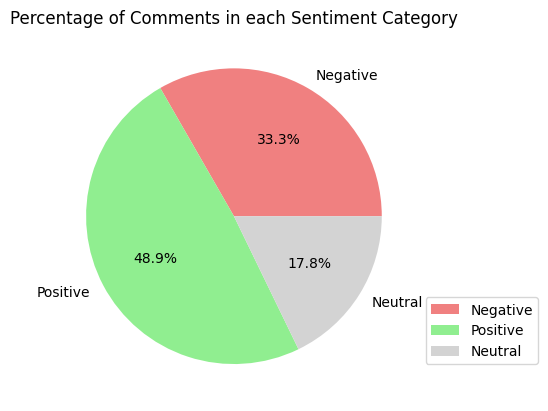

In [25]:
# visualize the distribution of sentiment category
senti_pie_count_list = []
senti_pie_count_list.append(len(semtiment_df[semtiment_df['compound'] < -0.05]))
senti_pie_count_list.append(len(semtiment_df[semtiment_df['compound'] > 0.05]))
senti_pie_count_list.append(len(semtiment_df[(semtiment_df['compound'] < 0.05) & (semtiment_df['compound'] > -0.05)]))

colors = ['lightcoral', 'lightgreen', 'lightgrey']
labels = ["Negative","Positive","Neutral"]

plt.pie(np.array(senti_pie_count_list),labels = labels, colors = colors,autopct='%1.1f%%')
plt.title("Percentage of Comments in each Sentiment Category")
plt.legend(bbox_to_anchor=(1, 0.3))
plt.show()

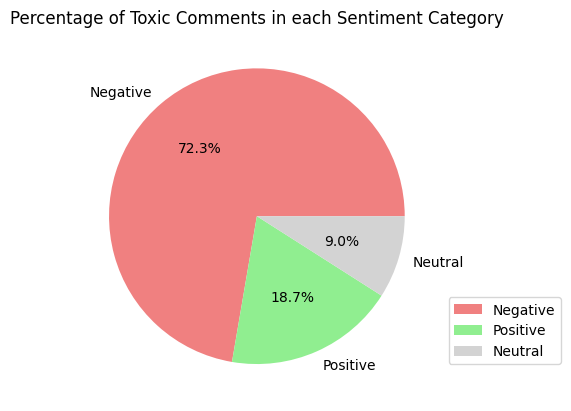

In [26]:
# visualize the distribution of sentiment category for toxic comments
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
semtiment_df_toxic = semtiment_df[semtiment_df[labels].sum(axis=1)>0]

senti_pie_count_list_toxic = []
senti_pie_count_list_toxic.append(len(semtiment_df_toxic[semtiment_df_toxic['compound'] < -0.05]))
senti_pie_count_list_toxic.append(len(semtiment_df_toxic[semtiment_df_toxic['compound'] > 0.05]))
senti_pie_count_list_toxic.append(len(semtiment_df_toxic[(semtiment_df_toxic['compound'] < 0.05) & (semtiment_df_toxic['compound'] > -0.05)]))

colors = ['lightcoral', 'lightgreen', 'lightgrey']
labels = ["Negative","Positive","Neutral"]

plt.pie(np.array(senti_pie_count_list_toxic),labels = labels, colors = colors,autopct='%1.1f%%')
plt.title("Percentage of Toxic Comments in each Sentiment Category")
plt.legend(bbox_to_anchor=(1, 0.3))
plt.show()

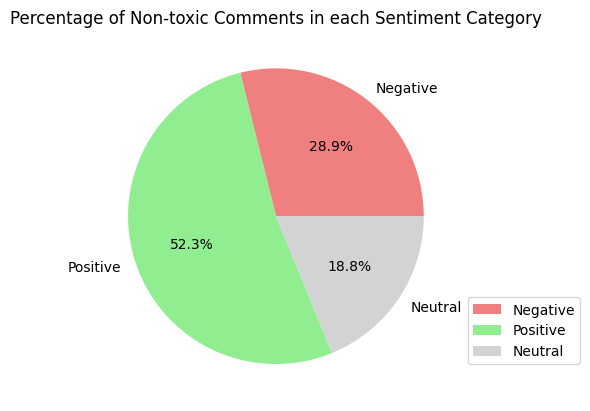

In [27]:
# visualize the distribution of sentiment category for non-toxic comments
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
semtiment_df_nontoxic = semtiment_df[semtiment_df[labels].sum(axis=1)==0]

senti_pie_count_list_nontoxic = []
senti_pie_count_list_nontoxic.append(len(semtiment_df_nontoxic[semtiment_df_nontoxic['compound'] < -0.05]))
senti_pie_count_list_nontoxic.append(len(semtiment_df_nontoxic[semtiment_df_nontoxic['compound'] > 0.05]))
senti_pie_count_list_nontoxic.append(len(semtiment_df_nontoxic[(semtiment_df_nontoxic['compound'] < 0.05) & (semtiment_df_nontoxic['compound'] > -0.05)]))

colors = ['lightcoral', 'lightgreen', 'lightgrey']
labels = ["Negative","Positive","Neutral"]

plt.pie(np.array(senti_pie_count_list_nontoxic),labels = labels, colors = colors,autopct='%1.1f%%')
plt.title("Percentage of Non-toxic Comments in each Sentiment Category")
plt.legend(bbox_to_anchor=(1, 0.3))
plt.show()

In [88]:
# test relationship between negative VADER score with toxic comments
semtiment_df['negative']= np.where(semtiment_df['compound'] < -0.05, 1, 0)
contigency= pd.crosstab(semtiment_df['negative'], semtiment_df['toxic'])
contigency

toxic,0,1
negative,,
0,102305,4126
1,41972,11168


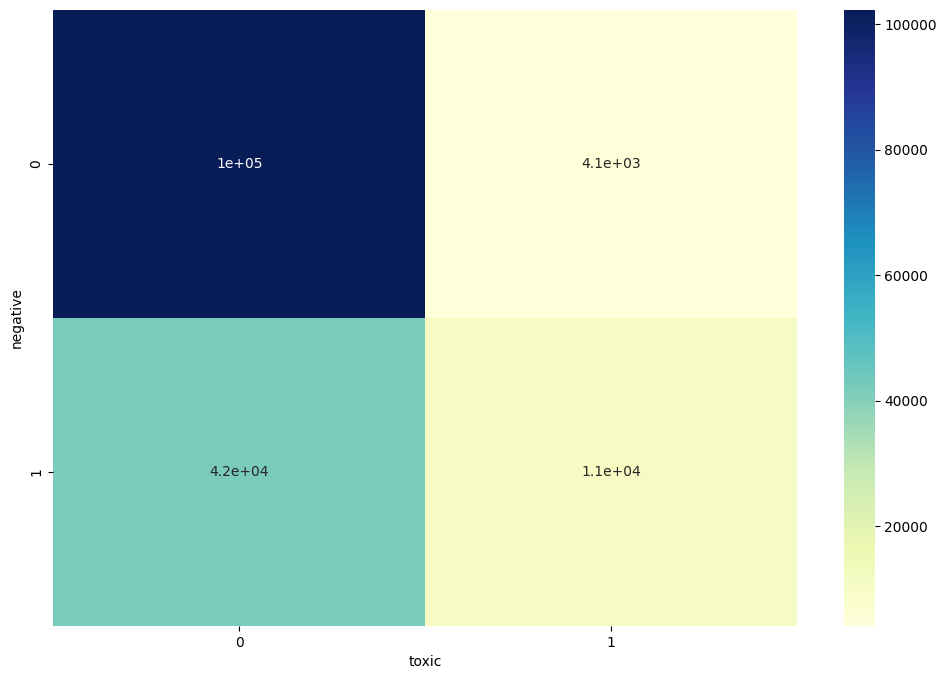

In [89]:
plt.figure(figsize=(12,8))
sns.heatmap(contigency, annot=True, cmap="YlGnBu")
plt.show()